<a href="https://colab.research.google.com/github/mshitie/MS_KD/blob/main/Teacher%26Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install rarfile

from google.colab import drive
import rarfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the .rar file in Google Drive
rar_path = '/content/drive/MyDrive/computer_vision/main_data_croped.rar'

# Destination folder to extract the contents
destination_folder = '/content'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Extract the .rar file
with rarfile.RarFile(rar_path, 'r') as rar_ref:
    rar_ref.extractall(destination_folder)

print("Extraction completed.")

Mounted at /content/drive
Extraction completed.


In [2]:
import os
import csv
import shutil
import random

def partition_images(directory, csv_file, output_folder):
    image_files = []
    folder_counts = {}  # Dictionary to store the count of images moved to each folder

    # Read the CSV file
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        header = next(reader, None)  # Skip the header row if it exists

        # Iterate over the rows in the CSV file
        for row in reader:
            image_file = row[0]  # Assuming the image file names are in the first column
            label = row[1]  # Assuming the labels are in the second column
            image_files.append((image_file, label))

    # Create directories for each label in training and testing folders
    labels = set(label for _, label in image_files)
    train_folder = os.path.join(output_folder, "training")
    test_folder = os.path.join(output_folder, "testing")
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    folder_counts["training"] = 0  # Initialize the count for training folder
    folder_counts["testing"] = 0  # Initialize the count for testing folder

    # Move the image files to separate label directories in training and testing folders
    for image_file, label in image_files:
        source_path = os.path.join(directory, image_file + ".jpg")  # Assuming the file extension is '.jpg'

        if os.path.exists(source_path):
            if random.random() < 0.2:
                destination_path = os.path.join(test_folder, label, image_file + ".jpg")
                folder_counts["testing"] += 1
            else:
                destination_path = os.path.join(train_folder, label, image_file + ".jpg")
                folder_counts["training"] += 1

            destination_dir = os.path.dirname(destination_path)
            os.makedirs(destination_dir, exist_ok=True)

            print(f"Moving {source_path} to {destination_path}")
            shutil.move(source_path, destination_path)
        else:
            print(f"File not found: {source_path}")

    # Print the counts for each folder
    print("\nNumber of images moved in each folder:")
    for folder, count in folder_counts.items():
        print(f"{folder}: {count}")

# Directory path where the images and CSV file are located
directory_path = '/content/main_data_croped/'
csv_file_path = '/content/drive/MyDrive/computer_vision/tfti2.csv'
output_folder = "/content/main_data_croped3/"

# Create the output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Call the function to partition the images based on the labels
partition_images(directory_path, csv_file_path, output_folder)

Moving /content/main_data_croped/image1.jpg to /content/main_data_croped3/training/1/image1.jpg
Moving /content/main_data_croped/image2.jpg to /content/main_data_croped3/training/2/image2.jpg
Moving /content/main_data_croped/image3.jpg to /content/main_data_croped3/training/1/image3.jpg
Moving /content/main_data_croped/image4.jpg to /content/main_data_croped3/training/1/image4.jpg
Moving /content/main_data_croped/image5.jpg to /content/main_data_croped3/training/2/image5.jpg
Moving /content/main_data_croped/image6.jpg to /content/main_data_croped3/training/3/image6.jpg
Moving /content/main_data_croped/image7.jpg to /content/main_data_croped3/training/1/image7.jpg
Moving /content/main_data_croped/image8.jpg to /content/main_data_croped3/training/4/image8.jpg
Moving /content/main_data_croped/image9.jpg to /content/main_data_croped3/training/1/image9.jpg
Moving /content/main_data_croped/image10.jpg to /content/main_data_croped3/training/4/image10.jpg
Moving /content/main_data_croped/image

In [3]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

import time
import timeit

<ipython-input-3-394d0b1b32f1>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

In [5]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

train_dir = '/content/main_data_croped3/training'
test_dir = '/content/main_data_croped3/testing'

# Load train images
tf_train = []
for filename in os.listdir(os.path.join(train_dir, 'TF')):
    img = Image.open(os.path.join(train_dir, 'TF', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    tf_train.append(img_array)
tf_train = np.array(tf_train)

it_train = []
for filename in os.listdir(os.path.join(train_dir, 'TI')):
    img = Image.open(os.path.join(train_dir, 'TI', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    it_train.append(img_array)
it_train = np.array(it_train)

normal_train = []
for filename in os.listdir(os.path.join(train_dir, 'normal')):
    img = Image.open(os.path.join(train_dir, 'normal', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    normal_train.append(img_array)
normal_train = np.array(normal_train)

# Load test images
tf_test = []
for filename in os.listdir(os.path.join(test_dir, 'TF')):
    img = Image.open(os.path.join(test_dir, 'TF', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    tf_test.append(img_array)
tf_test = np.array(tf_test)

it_test = []
for filename in os.listdir(os.path.join(test_dir, 'TI')):
    img = Image.open(os.path.join(test_dir, 'TI', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    it_test.append(img_array)
it_test = np.array(it_test)

normal_test = []
for filename in os.listdir(os.path.join(test_dir, 'normal')):
    img = Image.open(os.path.join(test_dir, 'normal', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    normal_test.append(img_array)
normal_test = np.array(normal_test)

print('Done Loaded :)')

# Shape of our dataset
print(f'TF Train:', tf_train.shape)
print(f'TI Train:', it_train.shape)
print(f'Normal Train:', normal_train.shape)
print(f'TF Test:', tf_test.shape)
print(f'TI Test:', it_test.shape)
print(f'Normal Test:', normal_test.shape)

tf_train_label = np.zeros(len(tf_train), dtype=float)
it_train_label = np.ones(len(it_train), dtype=float)
normal_train_label = np.full(len(normal_train), 2, dtype=float)
tf_test_label = np.zeros(len(tf_test), dtype=float)
it_test_label = np.ones(len(it_test), dtype=float)
normal_test_label = np.full(len(normal_test), 2, dtype=float)

X_train = np.concatenate((tf_train, it_train, normal_train), axis=0)
Y_train = np.concatenate((tf_train_label, it_train_label, normal_train_label), axis=0)
X_test = np.concatenate((tf_test, it_test, normal_test), axis=0)
Y_test = np.concatenate((tf_test_label, it_test_label, normal_test_label), axis=0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes=3)
Y_test = to_categorical(Y_test, num_classes=3)

print(f'X train shape:', X_train.shape)
print(f'X test shape:', X_test.shape)
print(f'Y train shape:', Y_train.shape)
print(f'Y test shape:', Y_test.shape)

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=5)

print(f'x train shape:', x_train.shape)
print(f'x val shape:', x_val.shape)
print(f'y train shape:', y_train.shape)
print(f'y val shape:', y_val.shape)

Done Loaded :)
TF Train: (289, 224, 224, 3)
TI Train: (84, 224, 224, 3)
Normal Train: (814, 224, 224, 3)
TF Test: (76, 224, 224, 3)
TI Test: (26, 224, 224, 3)
Normal Test: (205, 224, 224, 3)
X train shape: (1187, 224, 224, 3)
X test shape: (307, 224, 224, 3)
Y train shape: (1187, 3)
Y test shape: (307, 3)
x train shape: (949, 224, 224, 3)
x val shape: (238, 224, 224, 3)
y train shape: (949, 3)
y val shape: (238, 3)


In [6]:
from tensorflow.keras.applications import VGG16
# Teacher model with ResNet50
def build_model(backbone , lr = 1e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(3 , activation='softmax'))

  model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

  return model

resnet = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224 , 224 , 3)
)
# call the model
model = build_model(resnet , lr = 1e-4)
model.build((None, 224, 224, 3))
model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                         

In [7]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,verbose=1,factor=0.2, min_lr=1e-4)
filepath="ResNet50weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [8]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
# Configuration
import time
epochs = 30
batch_size = 64

# Calculate the starting time
start_time = time.time()

teacher_his = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_val, y_val),
            callbacks=[learn_control, checkpoint])


end_time = time.time()
print("--- Time taken to train : %s seconds ---" % ((end_time - start_time)))

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 1.1744 - accuracy: 0.5342

15/15 [==============================] - 67s 1s/step - loss: 1.1744 - accuracy: 0.5342 - val_loss: 1.0603 - val_accuracy: 0.4748 - lr: 1.0000e-04
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.4803 - accuracy: 0.8419

15/15 [==============================] - 10s 657ms/step - loss: 0.4803 - accuracy: 0.8419 - val_loss: 1.0931 - val_accuracy: 0.5588 - lr: 1.0000e-04
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9621

15/15 [==============================] - 10s 663ms/step - loss: 0.1388 - accuracy: 0.9621 - val_loss: 1.5318 - val_accuracy: 0.5630 - lr: 1.0000e-04
Epoch 4/30
15/15 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9874

15/15 [==============================] - 10s 669ms/step - loss: 0.0532 - accuracy: 0.9874 - val_loss: 2.9887 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/30
15/15 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.9947

15/15 [==============================] - 10s 677ms/step - loss: 0.0255 - accuracy: 0.9947 - val_loss: 2.7534 - val_accuracy: 0.5756 - lr: 1.0000e-04
Epoch 6/30
15/15 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9979

15/15 [==============================] - 10s 679ms/step - loss: 0.0186 - accuracy: 0.9979 - val_loss: 1.9582 - val_accuracy: 0.6555 - lr: 1.0000e-04
Epoch 7/30
15/15 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9947

15/15 [==============================] - 10s 687ms/step - loss: 0.0186 - accuracy: 0.9947 - val_loss: 2.9292 - val_accuracy: 0.5840 - lr: 1.0000e-04
Epoch 8/30
15/15 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 1.0000

15/15 [==============================] - 10s 657ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 2.4231 - val_accuracy: 0.6807 - lr: 1.0000e-04
Epoch 9/30
15/15 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9989

15/15 [==============================] - 11s 712ms/step - loss: 0.0074 - accuracy: 0.9989 - val_loss: 2.1452 - val_accuracy: 0.7269 - lr: 1.0000e-04
Epoch 10/30
15/15 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9989

15/15 [==============================] - 11s 708ms/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 1.7597 - val_accuracy: 0.7689 - lr: 1.0000e-04
Epoch 11/30
15/15 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9979

15/15 [==============================] - 10s 697ms/step - loss: 0.0082 - accuracy: 0.9979 - val_loss: 1.7513 - val_accuracy: 0.7983 - lr: 1.0000e-04
Epoch 12/30
15/15 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9989

15/15 [==============================] - 10s 652ms/step - loss: 0.0054 - accuracy: 0.9989 - val_loss: 1.6199 - val_accuracy: 0.7941 - lr: 1.0000e-04
Epoch 13/30
15/15 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

15/15 [==============================] - 10s 690ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.5377 - val_accuracy: 0.7815 - lr: 1.0000e-04
Epoch 14/30
15/15 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

15/15 [==============================] - 10s 692ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.3892 - val_accuracy: 0.7983 - lr: 1.0000e-04
Epoch 15/30
15/15 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

15/15 [==============================] - 10s 695ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.4866 - val_accuracy: 0.8025 - lr: 1.0000e-04
Epoch 16/30
15/15 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

15/15 [==============================] - 10s 700ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3908 - val_accuracy: 0.8067 - lr: 1.0000e-04
Epoch 17/30
15/15 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

15/15 [==============================] - 10s 703ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.2165 - val_accuracy: 0.8151 - lr: 1.0000e-04
Epoch 18/30
15/15 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

15/15 [==============================] - 10s 699ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.0430 - val_accuracy: 0.8361 - lr: 1.0000e-04
Epoch 19/30
15/15 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

15/15 [==============================] - 10s 698ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.0196 - val_accuracy: 0.8277 - lr: 1.0000e-04
Epoch 20/30
15/15 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9989

15/15 [==============================] - 10s 700ms/step - loss: 0.0024 - accuracy: 0.9989 - val_loss: 1.0879 - val_accuracy: 0.8403 - lr: 1.0000e-04
Epoch 21/30
15/15 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000    

15/15 [==============================] - 10s 656ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.1186 - val_accuracy: 0.8361 - lr: 1.0000e-04
Epoch 22/30
15/15 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

15/15 [==============================] - 10s 653ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.9910 - val_accuracy: 0.8193 - lr: 1.0000e-04
Epoch 23/30
15/15 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

15/15 [==============================] - 10s 653ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.0061 - val_accuracy: 0.8277 - lr: 1.0000e-04
Epoch 24/30
15/15 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

15/15 [==============================] - 10s 694ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.9236 - val_accuracy: 0.8319 - lr: 1.0000e-04
Epoch 25/30
15/15 [==============================] - ETA: 0s - loss: 9.6684e-04 - accuracy: 1.0000

15/15 [==============================] - 10s 697ms/step - loss: 9.6684e-04 - accuracy: 1.0000 - val_loss: 0.8983 - val_accuracy: 0.8361 - lr: 1.0000e-04
Epoch 26/30
15/15 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

15/15 [==============================] - 10s 652ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.8613 - val_accuracy: 0.8445 - lr: 1.0000e-04
Epoch 27/30
15/15 [==============================] - ETA: 0s - loss: 4.3893e-04 - accuracy: 1.0000

15/15 [==============================] - 10s 655ms/step - loss: 4.3893e-04 - accuracy: 1.0000 - val_loss: 0.8389 - val_accuracy: 0.8529 - lr: 1.0000e-04
Epoch 28/30
15/15 [==============================] - ETA: 0s - loss: 4.3287e-04 - accuracy: 1.0000

15/15 [==============================] - 10s 700ms/step - loss: 4.3287e-04 - accuracy: 1.0000 - val_loss: 0.8175 - val_accuracy: 0.8529 - lr: 1.0000e-04
Epoch 29/30
15/15 [==============================] - ETA: 0s - loss: 6.6518e-04 - accuracy: 1.0000

15/15 [==============================] - 10s 697ms/step - loss: 6.6518e-04 - accuracy: 1.0000 - val_loss: 0.8104 - val_accuracy: 0.8487 - lr: 1.0000e-04
Epoch 30/30
15/15 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

15/15 [==============================] - 10s 657ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7197 - val_accuracy: 0.8487 - lr: 1.0000e-04
--- Time taken to train : 396.45110034942627 seconds ---


In [9]:
model.save_weights("ResNet50_model.h5") #using h5 extension
print("model saved!!!")

model saved!!!


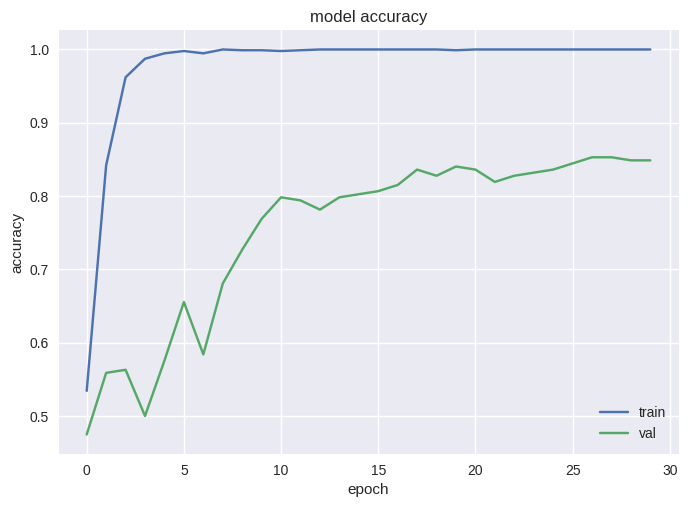

In [10]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

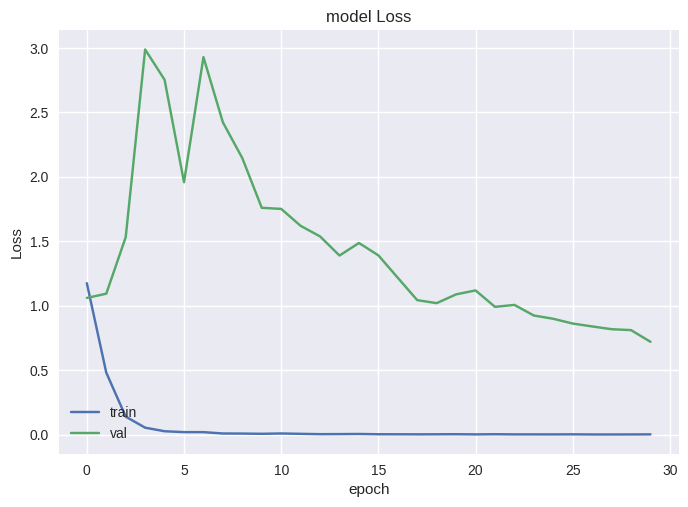

In [11]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [12]:
Y_val_pred = model.predict(x_val)
print(f'The Teacher model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

8/8 [==============================] - 7s 417ms/step
The Teacher model Accuracy on the Validation Set: 0.8487394957983193


In [13]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 

In [14]:
#Now let's check my predcited values from X_test dataset
# And calculate the y_pred with time
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = model.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

10/10 [==============================] - 2s 199ms/step
My predicted Y_test values are:
 [[9.99964476e-01 3.54844015e-05 9.53472002e-13]
 [8.87781475e-03 5.77622699e-03 9.85345960e-01]
 [1.13360502e-05 4.85371420e-04 9.99503255e-01]
 [5.24134338e-01 2.74202853e-01 2.01662764e-01]
 [1.75646517e-06 2.71527369e-05 9.99971032e-01]
 [9.99982834e-01 1.71406427e-05 1.83199526e-15]
 [2.43991344e-05 2.97773717e-04 9.99677896e-01]
 [2.79102027e-01 2.79051550e-02 6.92992866e-01]
 [1.14545386e-04 1.34759932e-03 9.98537898e-01]
 [9.98516142e-01 1.48390699e-03 1.91679845e-08]
 [9.90197539e-01 7.02704128e-04 9.09978710e-03]
 [2.04774231e-04 2.41795089e-03 9.97377276e-01]
 [9.81572986e-01 1.84270162e-02 1.75714288e-09]
 [2.59978719e-07 4.32200795e-05 9.99956489e-01]
 [8.17069411e-03 9.15639196e-03 9.82672930e-01]
 [9.99980569e-01 1.94616932e-05 5.67132192e-18]
 [3.32410011e-04 9.99430358e-01 2.37224696e-04]
 [5.64017951e-01 4.20622051e-01 1.53600471e-02]
 [4.90696664e-07 2.29769848e-05 9.99976516e-01]


In [15]:
start = timeit.default_timer()
#Your statements here

#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Teacher model with ResNet50 on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My accuracy on Teacher model with ResNet50 on the Test set is: 0.8175895765472313

Time:  0.003314491000082853 sec


In [16]:
# Classification_report
print(f'Classification Report of Resnet50:\n',classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.72      0.66      0.69        76
           1       0.72      0.69      0.71        26
           2       0.86      0.89      0.88       205

    accuracy                           0.82       307
   macro avg       0.77      0.75      0.76       307
weighted avg       0.81      0.82      0.82       307



**AUC ROC**

Auc Curve on Validation:



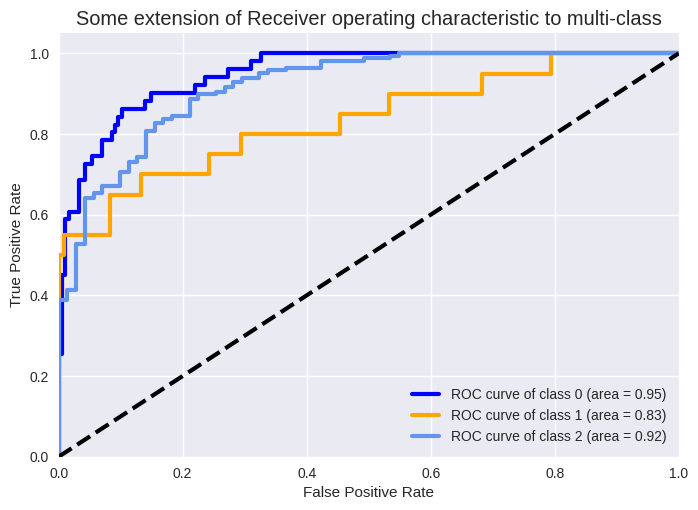

In [17]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], Y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), Y_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



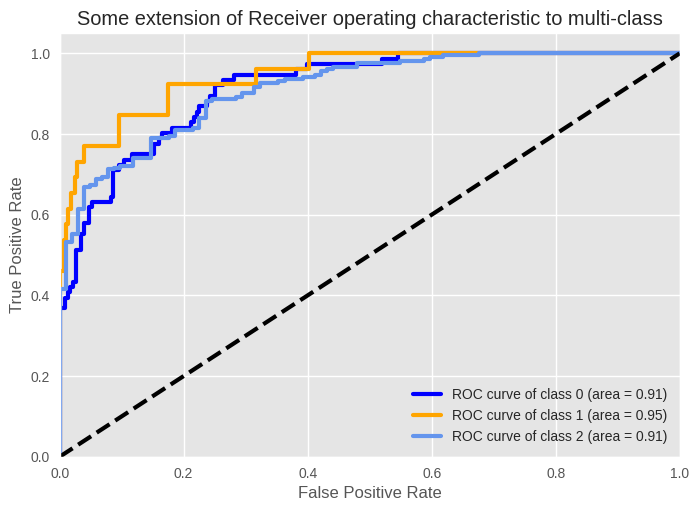

In [18]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

**Student Model**

In [19]:
# Define the student model
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model
# Hyperparameters
input_shape = (224, 224, 3) # Input shape of each image
nb_classes = 3

customstudent = Sequential()
customstudent.add(Conv2D(128, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(64, (3, 3), activation='relu'))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(32, (3, 3), activation='relu'))
customstudent.add(Dropout(0.25)) # For reguralization

customstudent.add(layers.Flatten())

customstudent.add(layers.Dense(nb_classes))
customstudent.add(layers.Activation('softmax')) # Note that we add a normal softmax layer to begin with


customstudent.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

print(customstudent.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        18464     
                                                                 
 dropout_1 (Dropout)         (None, 52, 52, 32)       

In [21]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets

# Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense').output)

In [22]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

In [23]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val)

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

8/8 [==============================] - 1s 90ms/step
(949, 3)
(238, 3)
(949, 6)
(238, 6)


In [24]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
temp = 10
customstudent.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = customstudent.layers[-1].output
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model
customstudent = Model(customstudent.input, output)

customstudent.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 128)        3584      ['conv2d_input[0][0]']        
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)        0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         73792     ['max_pooling2d[0][0]'] 

In [25]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model.
# This uses a knowledge distillation loss function
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]

    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]

    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)

    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

customstudent.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc]
  )

In [27]:
# Train the student model
epochs = 30
batch_size = 64
customstudent_student_his = customstudent.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/30
15/15 [==============================] - 13s 918ms/step - loss: 0.1383 - acc: 0.1707 - val_loss: 0.1376 - val_acc: 0.2143
Epoch 2/30
15/15 [==============================] - 8s 503ms/step - loss: 0.1100 - acc: 0.4510 - val_loss: 0.0891 - val_acc: 0.7017
Epoch 3/30
15/15 [==============================] - 7s 502ms/step - loss: 0.0900 - acc: 0.6607 - val_loss: 0.0891 - val_acc: 0.7017
Epoch 4/30
15/15 [==============================] - 7s 499ms/step - loss: 0.0894 - acc: 0.6681 - val_loss: 0.0891 - val_acc: 0.7017
Epoch 5/30
15/15 [==============================] - 7s 492ms/step - loss: 0.0883 - acc: 0.6797 - val_loss: 0.0891 - val_acc: 0.7017
Epoch 6/30
15/15 [==============================] - 7s 491ms/step - loss: 0.0879 - acc: 0.6818 - val_loss: 0.0891 - val_acc: 0.7017
Epoch 7/30
15/15 [==============================] - 7s 501ms/step - loss: 0.0882 - acc: 0.6797 - val_loss: 0.0891 - val_acc: 0.7017
Epoch 8/30
15/15 [==============================] - 7s 500ms/step - loss: 0

<ipython-input-28-4dfd3e4fd4f9>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


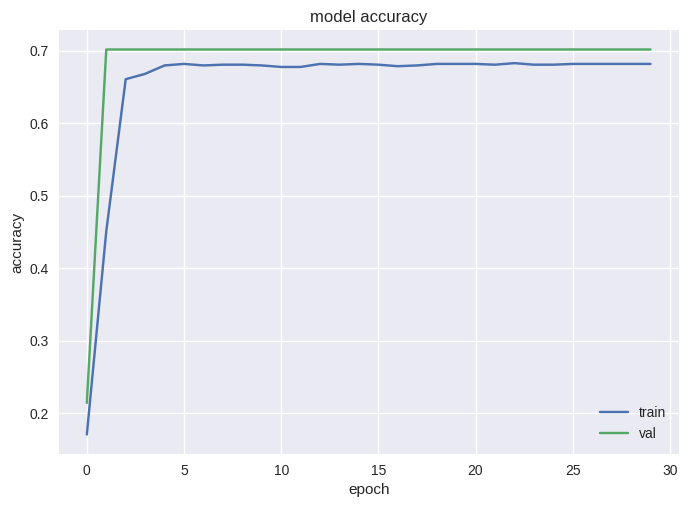

In [28]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.style.use('seaborn')
plt.plot(customstudent_student_his.history['acc'])
plt.plot(customstudent_student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

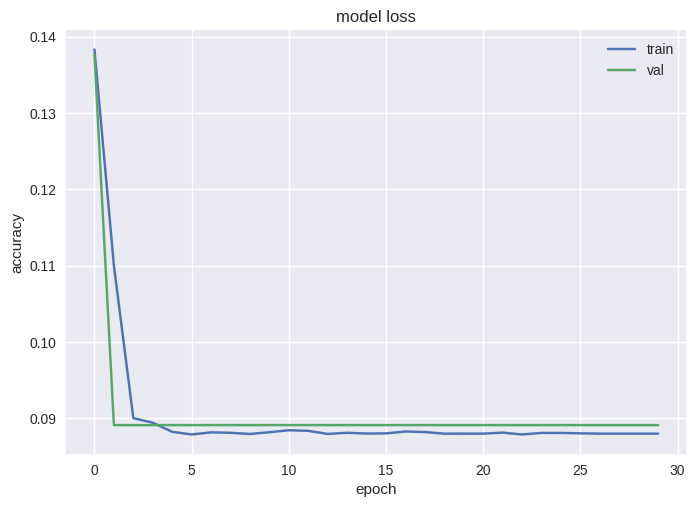

In [29]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(customstudent_student_his.history['loss'])
plt.plot(customstudent_student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [30]:
Y_val_pred_student = customstudent.predict(x_val)
print(f'The CustomStudent model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred_student, axis=1)))

8/8 [==============================] - 2s 86ms/step
The CustomStudent model Accuracy on the Validation Set: 0.7016806722689075


In [31]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 

In [32]:
#Now let's check my predcited values from X_test dataset
import timeit

start = timeit.default_timer()
#Your statements here
y_pred_student = customstudent.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred_student)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

10/10 [==============================] - 1s 94ms/step
My predicted Y_test values are:
 [[0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 ...
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]]

Time:  1.0002006209999763 sec


In [33]:
start = timeit.default_timer()
#Your statements here

#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Custom Student model on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred_student, axis=1)))

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My accuracy on Custom Student model on the Test set is: 0.6677524429967426

Time:  0.001085542999817335 sec


In [34]:
# Classification_report
print(f'Classification Report of Resnet50:\n',classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred_student, axis=1)))

Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        76
           1       0.00      0.00      0.00        26
           2       0.67      1.00      0.80       205

    accuracy                           0.67       307
   macro avg       0.22      0.33      0.27       307
weighted avg       0.45      0.67      0.53       307



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Auc Curve on Validation:



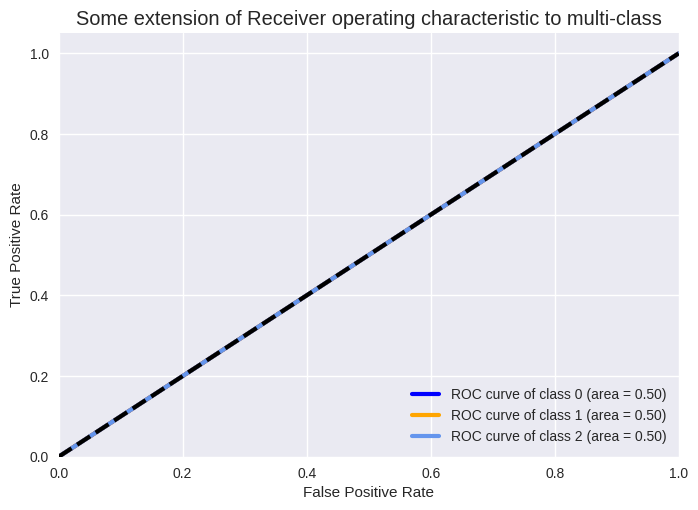

In [35]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_new[:, i], Y_val_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_new.ravel(), Y_val_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



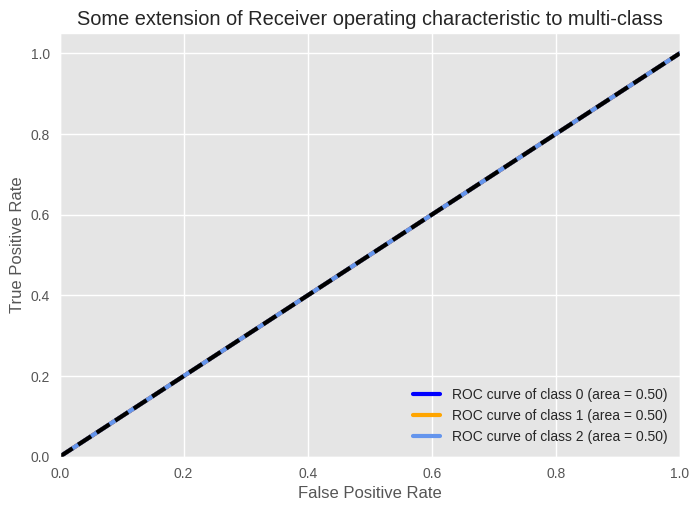

In [36]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [37]:

from tensorflow.keras.applications import MobileNet

def mobile_model1(backbone , lr = 1e-4):
  model1 = Sequential()
  model1.add(backbone)
  model1.add(layers.GlobalAveragePooling2D())
  model1.add(layers.Dropout(0.5))
  model1.add(layers.BatchNormalization())
  model1.add(layers.Dense(3 , activation='softmax'))

  model1.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )

  return model1


mobilenet1 = MobileNet(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
#call the model
model1 = mobile_model1(mobilenet1 , lr = 1e-4)
model1.build((None, 224, 224, 3))
model1.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 3)                 

In [38]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets
#Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense').output)

In [39]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

1/1 [==============================] - 1s 1s/step
[[0.21194184 0.21194255 0.5761156 ]]




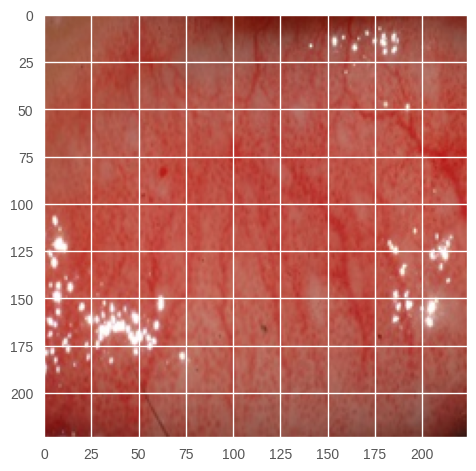

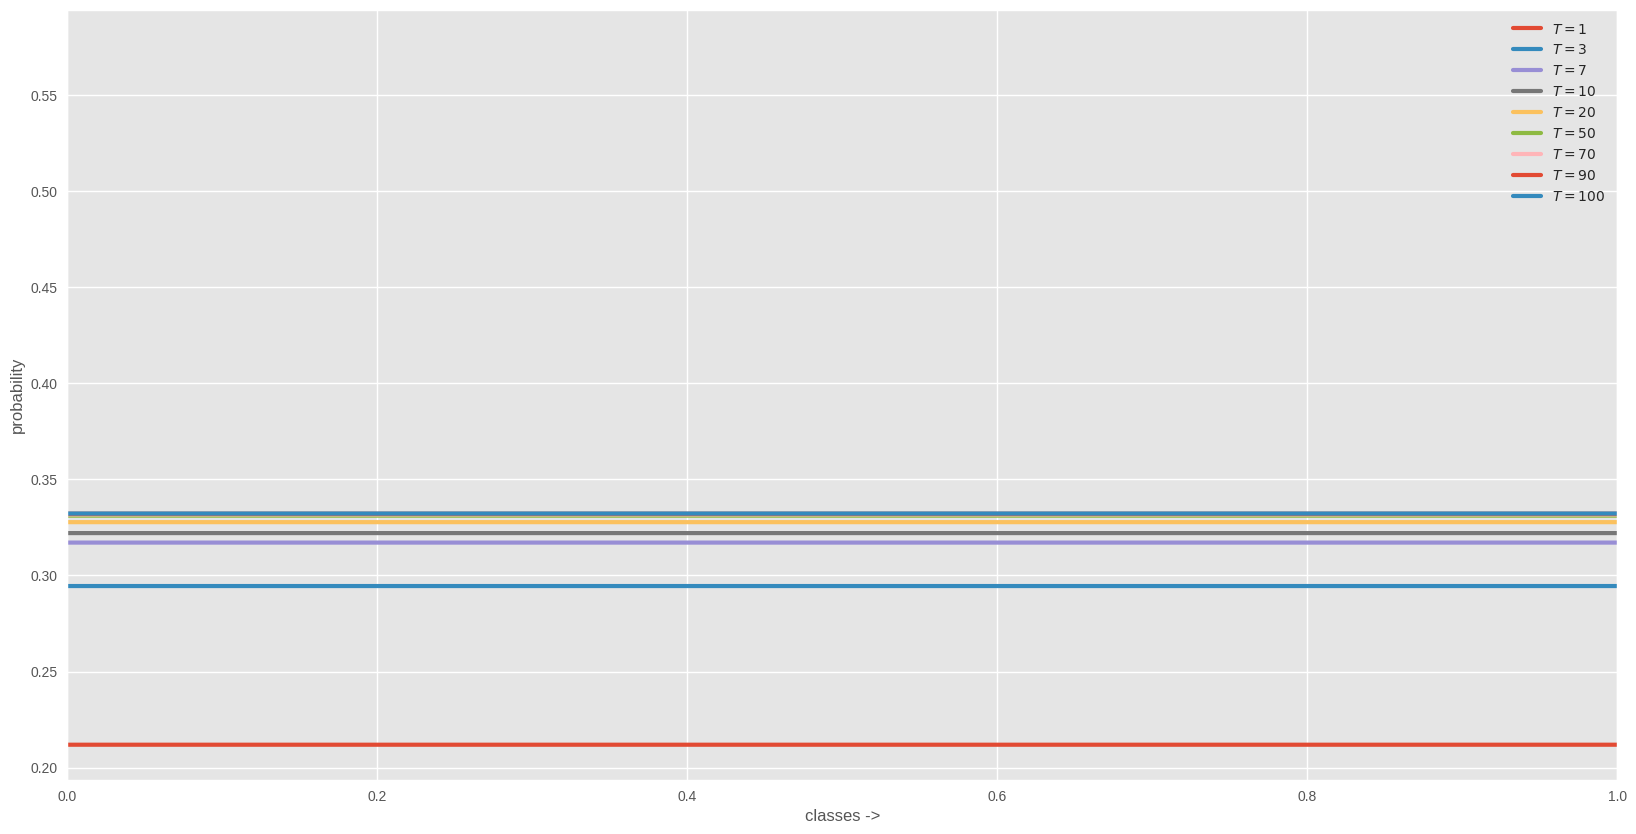

In [40]:

# For example, just grab the first image and lets see how softening of probabilities work
intermediate_output = teacher_WO_Softmax.predict(x_train[122].reshape(1,224,224,3))
print(softmax(intermediate_output))
print('\n')

pixels = x_train[122]
pixels = pixels.reshape((224, 224, 3))
plt.imshow(pixels)
plt.show()
print('\n')

# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize = (20, 10));

temperature = [1,3,7,10,20,50,70,90,100]

for temp in temperature:
    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=3);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 1]);
plt.show()

In [41]:

# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val)

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

8/8 [==============================] - 1s 89ms/step
(949, 3)
(238, 3)
(949, 6)
(238, 6)


In [42]:

# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
model1.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = model1.layers[-1].output
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model as mobileNet
model1 = Model(model1.input, output)

model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mobilenet_1.00_224_input (  [(None, 224, 224, 3)]        0         []                            
 InputLayer)                                                                                      
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)           3228864   ['mobilenet_1.00_224_input[0][
 onal)                                                              0]']                          
                                                                                                  
 global_average_pooling2d_1  (None, 1024)                 0         ['mobilenet_1.00_224[0][0]']  
  (GlobalAveragePooling2D)                                                                  

In [43]:
#Distill Loss Function
# Declare knowledge distillation loss function
# This will be a teacher trained student model.
# This uses a knowledge distillation loss function
nb_classes = 3
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]

    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]

    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)

    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

model1.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc]
  )


# Train the student model with MobileNet
epochs = 20
batch_size = 64
student_his = model1.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/20
15/15 [==============================] - 22s 453ms/step - loss: 0.1140 - acc: 0.3593 - val_loss: 0.1091 - val_acc: 0.4916
Epoch 2/20
15/15 [==============================] - 4s 242ms/step - loss: 0.1133 - acc: 0.3446 - val_loss: 0.1040 - val_acc: 0.5882
Epoch 3/20
15/15 [==============================] - 4s 246ms/step - loss: 0.1135 - acc: 0.3562 - val_loss: 0.1037 - val_acc: 0.6092
Epoch 4/20
15/15 [==============================] - 4s 247ms/step - loss: 0.1141 - acc: 0.3404 - val_loss: 0.1036 - val_acc: 0.5756
Epoch 5/20
15/15 [==============================] - 4s 240ms/step - loss: 0.1137 - acc: 0.3425 - val_loss: 0.1040 - val_acc: 0.5420
Epoch 6/20
15/15 [==============================] - 4s 238ms/step - loss: 0.1143 - acc: 0.3383 - val_loss: 0.1063 - val_acc: 0.5042
Epoch 7/20
15/15 [==============================] - 4s 237ms/step - loss: 0.1126 - acc: 0.3678 - val_loss: 0.1078 - val_acc: 0.4874
Epoch 8/20
15/15 [==============================] - 4s 246ms/step - loss: 0

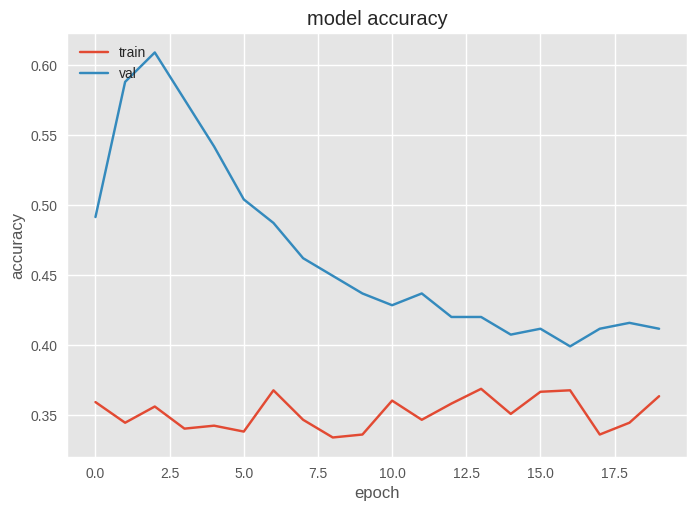

In [44]:

#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(student_his.history['acc'])
plt.plot(student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

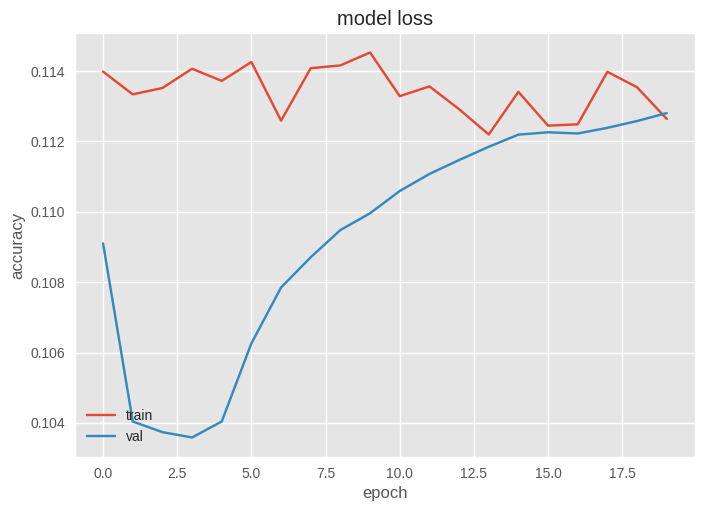

In [45]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(student_his.history['loss'])
plt.plot(student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()


In [46]:
Y_val_pred = model.predict(x_val)
print(f'The MobileNet model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))


8/8 [==============================] - 1s 97ms/step
The MobileNet model Accuracy on the Validation Set: 0.8487394957983193


In [47]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 

In [48]:
#Now let's check my predcited values from X_test dataset
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = model1.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

10/10 [==============================] - 2s 67ms/step
My predicted Y_test values are:
 [[0.46466035 0.28851533 0.24682432 0.34576252 0.32967138 0.3245661 ]
 [0.32053074 0.3878039  0.2916654  0.33224332 0.33863395 0.32912266]
 [0.49021655 0.24805026 0.2617332  0.3480291  0.3251103  0.32686064]
 ...
 [0.26676637 0.27503482 0.4581988  0.3269427  0.3279422  0.34511507]
 [0.34099242 0.26164356 0.39736402 0.33452904 0.32578447 0.33968645]
 [0.32890025 0.4018081  0.26929164 0.33328596 0.3400263  0.32668778]]

Time:  1.6609121269998468 sec


In [50]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Student model with MobileNet on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))


My accuracy on Student model with MobileNet on the Test set is: 0.3713355048859935


In [52]:
# Print the classification report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.27      0.39      0.32        76
           1       0.06      0.23      0.10        26
           2       0.80      0.38      0.51       205

    accuracy                           0.37       307
   macro avg       0.38      0.34      0.31       307
weighted avg       0.60      0.37      0.43       307



In [55]:

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test_new_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
from sklearn.metrics import roc_auc_score
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)


# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('\nFalse Positive Rate')
# y label
plt.ylabel('\nTrue Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

NameError: ignored

-----